*   Nama: Raina Imtiyaz
*   NIM: 2502010976
*   Link Video: https://binusianorg-my.sharepoint.com/personal/raina_imtiyaz_binus_ac_id/_layouts/15/guestaccess.aspx?guestaccesstoken=FIPGNay%2BL%2FcQWFv%2Bimw%2BN2trFutVhTNLLZj9Nqf8pNk%3D&docid=2_07aa549ec056b44ff8ae189d32382e69d&rev=1&e=J3hBhv



In [1]:
# Import Library yang digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.layers import Dropout

import os
import random

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

### Dataset Cisco Systems, Inc

In [2]:
df1 = pd.read_csv("CSCO.csv")
df1 = df1[['Date','Close']]

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7589 non-null   object 
 1   Close   7589 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


df1 mempunyai 2 kolom dengan 7589 entries.

In [4]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.sort_values('Date', ascending=True)
df1['day'] = df1['Date'].dt.day_name()
df1['next_day'] = df1['Date'].shift(-1).dt.day_name()

Code di atas untuk melakukan beberapa manipulasi pada dataframe df1. Pertama, code tersebut mengubah kolom "Date" menjadi tipe data datetime menggunakan fungsi pd.to_datetime(). Kemudian, dataframe df1 diurutkan berdasarkan nilai kolom "Date" secara ascending (ascending=True) menggunakan fungsi sort_values(). Selanjutnya, code tersebut menambahkan kolom baru bernama "day" yang berisi nama hari dari kolom "Date" menggunakan atribut dt.day_name(). Terakhir, code tersebut menambahkan kolom baru bernama "next_day" yang berisi nama hari dari tanggal selanjutnya dengan menggunakan fungsi shift() dan dt.day_name(). Kolom "next_day" ini berisi nama hari dari tanggal setelahnya dalam urutan yang sama seperti data asli pada kolom "Date".

In [5]:
df1.head(20)

,Date,Close,day,next_day
0,1990-02-16,0.077257,Friday,Tuesday
1,1990-02-20,0.079861,Tuesday,Wednesday
2,1990-02-21,0.078125,Wednesday,Thursday
3,1990-02-22,0.078993,Thursday,Friday
4,1990-02-23,0.078559,Friday,Monday
5,1990-02-26,0.076389,Monday,Tuesday
6,1990-02-27,0.078125,Tuesday,Wednesday
7,1990-02-28,0.080729,Wednesday,Thursday
8,1990-03-01,0.079861,Thursday,Friday
9,1990-03-02,0.080729,Friday,Monday


In [6]:
df1.tail(20)

,Date,Close,day,next_day
7569,2020-03-05,39.570000,Thursday,Friday
7570,2020-03-06,39.680000,Friday,Monday
7571,2020-03-09,37.959999,Monday,Tuesday
7572,2020-03-10,40.080002,Tuesday,Wednesday
7573,2020-03-11,37.049999,Wednesday,Thursday
7574,2020-03-12,33.200001,Thursday,Friday
7575,2020-03-13,37.639999,Friday,Monday
7576,2020-03-16,33.709999,Monday,Tuesday
7577,2020-03-17,35.500000,Tuesday,Wednesday
7578,2020-03-18,37.119999,Wednesday,Thursday


Dari sampel data di atas terlihat bahwa terdapat beberapa data pengamatan yang hilang, misalnya pada data tanggal 1990-02-16 yaitu Friday, tapi hari pada baris selanjutnya adalah Tuesday yang dimana seharusnya Monday.

In [7]:
df1.isnull().sum()

Date        0
Close       0
day         0
next_day    1
dtype: int64

Code di atas menghitung jumlah nilai null (NaN) dalam setiap kolom dataframe df1 menggunakan metode isnull() dan sum(). Hasilnya adalah sebuah series yang menunjukkan jumlah nilai null dalam setiap kolom dataframe. Terlihat bahwa pada kolom next day terdapat 1 missing value. Hal ini diakibatkan karena tidak ada data berikutnya setelah tanggal 2020-04-01 sehingga menghasilkan next day NaN. Jika dilihat berdsarkan kolom day maka dapat digantikan dengan variabel Thursday.

In [8]:
df1.fillna("Thursday", inplace=True)

Dari penjelasan sebelumnya code di atas menggantikan nilai null (NaN) dalam dataframe df1 dengan string "Thursday" menggunakan fungsi fillna(). Dengan parameter inplace=True, penggantian dilakukan secara langsung pada dataframe df1 tanpa perlu menyimpan hasilnya ke dalam variabel baru.

In [9]:
def check_day_order(day, next_day):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day_index = days.index(day)
    next_day_index = days.index(next_day)
    if day == 'Monday' and next_day == 'Tuesday':
        return 1
    elif day == 'Friday' and next_day == 'Monday':
        return 1
    elif next_day_index == (day_index + 1) % len(days):
        return 1
    else:
        return 0

* Code di atas mendefinisikan sebuah function yang bernama check_day_order() dengan dua parameter, yaitu "day" dan "next_day". Function ini digunakan untuk memeriksa urutan hari antara "day" dan "next_day" yang diberikan.

* Pada bagian awal, terdapat inisialisasi variabel "days" yang berisi daftar hari dalam urutan: 'Monday', 'Tuesday', 'Wednesday', 'Thursday', dan 'Friday'. Kemudian function ini mengambil indeks hari "day" dan "next_day" dalam daftar "days" menggunakan metode index() dan menyimpannya dalam variabel "day_index" dan "next_day_index" secara berturut-turut.

* Kemudian dilakukan pemeriksaan urutan hari antara "day" dan "next_day". Pertama, jika "day" adalah 'Monday' dan "next_day" adalah 'Tuesday', function akan mengembalikan nilai 1. Selanjutnya, jika "day" adalah 'Friday' dan "next_day" adalah 'Monday', fungsi juga akan mengembalikan nilai 1. Hal ini mengindikasikan bahwa urutan hari dari 'Friday' ke 'Monday' atau dari 'Monday' ke 'Tuesday' dianggap benar.

* Selain itu, function di atas juga memeriksa apakah indeks "next_day" adalah hasil dari penambahan 1 terhadap "day_index" (dengan menggunakan operasi modulus len(days)). Jika kondisi tersebut terpenuhi, function akan mengembalikan nilai 1, yang menunjukkan urutan hari yang benar.

* Jika semua kondisi tidak terpenuhi, function akan mengembalikan nilai 0, yang menandakan bahwa urutan hari antara "day" dan "next_day" tidak sesuai.

* Dengan menggunakan function ini, urutan hari dalam df1 dapat diperiksa kebenarannya.

In [10]:
# Penerapan function check_day_order
df1['ordered'] = df1.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

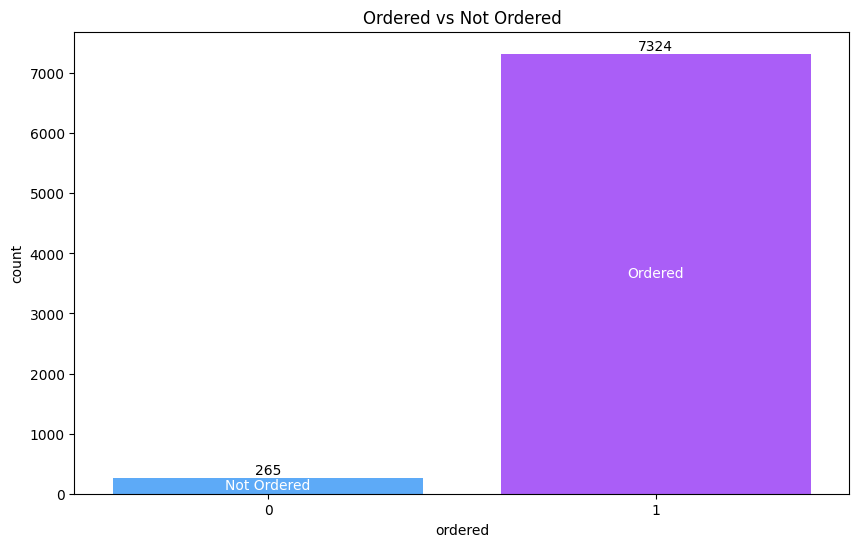

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = df1, x ='ordered', palette='cool',
                    saturation=0.9)
for container in ax.containers:
    ax.bar_label(container)
ax.bar_label(container=ax.containers[0], labels=['Not Ordered', 'Ordered'],
              label_type='center', size=10, color='w')
plt.title("Ordered vs Not Ordered")
plt.show()

Dari output di atas dapat dilihat bahwa terdapat 265 pengamatan yang tidak berurutan dengan data pengamatan berikutnya. Oleh karena itu akan dilakukan interpolasi sehingga data time series yang diperoleh lengkap secara daily. Untuk kolom Close akan diduga berdasarkan nilai Close sebelum dan sesudah pengamatan yang akan dilengkapi.

In [12]:
df1 = df1.drop("next_day", axis=1)

# Mengubah index dataframe menjadi kolom "Date"
df1 = df1.set_index('Date')

# Membuat range tanggal mulai dari tanggal pertama hingga tanggal terakhir
date_range = pd.date_range(start=df1.index.min(), end=df1.index.max(), freq='D')

# Membuat dataframe baru dengan index berdasarkan range tanggal
df2 = pd.DataFrame(index=date_range)

# Menggabungkan dataframe df1 dengan df2 untuk melengkapi tanggal
df_complete = df2.merge(df1, how='left', left_index=True, right_index=True)

# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai sebelum dan sesudahnya
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)

# Mengatur ulang index menjadi kolom "Date"
df_complete = df_complete.reset_index()

df_complete=df_complete.rename(columns={"index": "Date"})

# Mengurutkan dataframe berdasarkan kolom "Date"
df_complete = df_complete.sort_values('Date')

# Mengubah tipe data kolom "Date" menjadi string
df_complete['Date'] = df_complete['Date'].dt.strftime('%Y-%m-%d')

* Code di atas melakukan beberapa operasi pada dataframe df1 untuk melengkapi tanggal yang hilang dan melakukan beberapa perubahan pada data.

* Pertama, code tersebut menggunakan fungsi drop() untuk menghapus kolom "next_day" dari dataframe df1. Dalam hal ini, axis=1 digunakan untuk mengindikasikan bahwa yang dihapus adalah sebuah kolom.

* Selanjutnya, code tersebut menggunakan set_index() untuk mengubah indeks dataframe df1 menjadi kolom "Date". Dengan demikian, kolom "Date" tidak lagi berfungsi sebagai indeks.

* Kemudian, code tersebut menggunakan fungsi date_range() untuk membuat rentang tanggal mulai dari tanggal pertama hingga tanggal terakhir yang ada dalam dataframe df1. Frekuensi yang digunakan adalah 'D', yang berarti harian.

* Selanjutnya, code tersebut membuat dataframe baru dengan menggunakan pd.DataFrame() dan mengatur indexnya berdasarkan range tanggal yang telah dibuat sebelumnya. Dataframe baru ini disimpan dalam variabel df2.

* Selanjutnya, code tersebut menggunakan merge() untuk menggabungkan dataframe df1 dengan df2 menggunakan kolom-kolom yang sesuai. Tujuannya adalah untuk melengkapi tanggal yang mungkin hilang pada dataframe df1. Penggabungan dilakukan dengan menggunakan left join (how='left') berdasarkan index pada kedua dataframe.

* Setelah itu, code tersebut mengisi nilai kosong (NaN) pada kolom "Close" dengan menggunakan rata-rata dari nilai sebelum dan sesudahnya. Hal ini dilakukan dengan menggunakan fungsi fillna() dan shift() untuk mendapatkan nilai sebelum dan sesudahnya.

* Selanjutnya, code tersebut menggunakan reset_index() untuk mengatur ulang indeks dataframe menjadi kolom "Date".

* Selanjutnya, code tersebut menggunakan rename() untuk mengganti nama kolom "index" menjadi "Date" pada dataframe df_complete.

* Kemudian, code tersebut menggunakan sort_values() untuk mengurutkan dataframe df_complete berdasarkan kolom "Date".

* Terakhir, code tersebut menggunakan strftime() untuk mengubah tipe data kolom "Date" menjadi string dengan format tahun-bulan-tanggal ('%Y-%m-%d').

In [13]:
df_complete

,Date,Close,day,ordered
0,1990-02-16,0.077257,Friday,0.0
1,1990-02-17,NaN,NaN,NaN
2,1990-02-18,NaN,NaN,NaN
3,1990-02-19,NaN,NaN,NaN
4,1990-02-20,0.079861,Tuesday,1.0
...,...,...,...,...
10998,2020-03-28,NaN,NaN,NaN
10999,2020-03-29,NaN,NaN,NaN
11000,2020-03-30,40.320000,Monday,1.0
11001,2020-03-31,39.310001,Tuesday,1.0


In [14]:
# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai terdekat
df_complete['Close'] = df_complete['Close'].fillna(df_complete['Close'].interpolate())

* Code di atas mengisi nilai kosong (NaN) pada kolom "Close" dalam dataframe df_complete dengan menggunakan metode interpolasi.

* Dalam code tersebut, df_complete['Close'].interpolate() digunakan untuk menghasilkan serangkaian nilai yang dihasilkan dari interpolasi linier terhadap nilai yang tersedia di kolom "Close". Interpolasi linier ini mengisi nilai yang hilang dengan nilai rata-rata dari nilai sebelum dan sesudahnya.

* Selanjutnya, hasil dari interpolasi linier ini diassign kembali ke kolom "Close" dalam dataframe df_complete menggunakan df_complete['Close'] = df_complete['Close'].fillna(...).

* Dengan demikian, nilai kosong dalam kolom "Close" akan diisi dengan rata-rata dari nilai sebelum dan sesudahnya menggunakan metode interpolasi linier.

In [15]:
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete['day'] = df_complete['Date'].dt.day_name()

In [16]:
df_final = df_complete[~df_complete.day.isin(['Saturday',"Sunday"])]

* Setelah data dilengkapi secara daily maka Code berikut untuk menghilangkan data yang merupakan Saturday dan Sunday.

* Dalam code tersebut, ~ digunakan sebagai operator negasi untuk mengambil data yang tidak memenuhi kondisi yang diberikan. Dalam hal ini, kita ingin mengambil data di mana kolom "day" bukan merupakan hari Sabtu ('Saturday') atau Minggu ('Sunday').

* Jadi, df_final akan berisi data dari df_complete yang tidak jatuh pada hari Sabtu atau Minggu.

In [17]:
df_final['next_day'] = df_final['Date'].shift(-1).dt.day_name()
df_final=df_final.drop(['ordered'], axis=1).reset_index(drop=True)

<ipython-input-17-8841f38a4ef5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['next_day'] = df_final['Date'].shift(-1).dt.day_name()


In [18]:
df_final

,Date,Close,day,next_day
0,1990-02-16,0.077257,Friday,Monday
1,1990-02-19,0.079210,Monday,Tuesday
2,1990-02-20,0.079861,Tuesday,Wednesday
3,1990-02-21,0.078125,Wednesday,Thursday
4,1990-02-22,0.078993,Thursday,Friday
...,...,...,...,...
7854,2020-03-26,40.580002,Thursday,Friday
7855,2020-03-27,38.820000,Friday,Monday
7856,2020-03-30,40.320000,Monday,Tuesday
7857,2020-03-31,39.310001,Tuesday,Wednesday


In [19]:
df_final.fillna("Thursday", inplace=True)
df_final['ordered'] = df_final.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

In [20]:
df_final.ordered.value_counts()

1    7859
Name: ordered, dtype: int64

Dari output di atas terlihat bahwa semua data sudah berurutan.

In [21]:
df_final

,Date,Close,day,next_day,ordered
0,1990-02-16,0.077257,Friday,Monday,1
1,1990-02-19,0.079210,Monday,Tuesday,1
2,1990-02-20,0.079861,Tuesday,Wednesday,1
3,1990-02-21,0.078125,Wednesday,Thursday,1
4,1990-02-22,0.078993,Thursday,Friday,1
...,...,...,...,...,...
7854,2020-03-26,40.580002,Thursday,Friday,1
7855,2020-03-27,38.820000,Friday,Monday,1
7856,2020-03-30,40.320000,Monday,Tuesday,1
7857,2020-03-31,39.310001,Tuesday,Wednesday,1


In [22]:
# Menentukan window size dan horizon
window_size = 5
horizon = 1

# Memisahkan data time series menjadi input dan output
input_data = []
output_data = []
for i in range(len(df_final) - window_size - horizon + 1):
    if df_final['day'].iloc[i:i+window_size].eq(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).all() and df_final['day'].iloc[i + window_size:i+window_size + horizon].eq('Monday').all():
        input_data.append(df_final['Close'].iloc[i:i+window_size].values)
        output_data.append(df_final['Close'].iloc[i+window_size:i+window_size+horizon].values)

# Konversi menjadi DataFrame
input_df = pd.DataFrame(input_data, columns=[f'lag_{i}' for i in range(1, window_size + 1)])
output_df = pd.DataFrame(output_data, columns=['output'])

# Membagi dataset menjadi training, testing, dan validation set
total_samples = len(input_df)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)

train_input = input_df[:train_size]
train_output = output_df[:train_size]

val_input = input_df[train_size:train_size + val_size]
val_output = output_df[train_size:train_size + val_size]

test_input = input_df[train_size + val_size:]
test_output = output_df[train_size + val_size:]

# Menampilkan hasil
print("Training Data:")
print(train_input.shape)
print(train_output.shape)
print()
print("Validation Data:")
print(val_input.shape)
print(val_output.shape)
print()
print("Testing Data:")
print(test_input.shape)
print(test_output.shape)

Training Data:
(1256, 5)
(1256, 1)

Validation Data:
(157, 5)
(157, 1)

Testing Data:
(158, 5)
(158, 1)


* Code di atas melakukan beberapa langkah untuk mempersiapkan data dalam bentuk time series untuk digunakan dalam pelatihan dan pengujian model.

* Pertama, code tersebut menentukan window_size dan horizon yang akan digunakan dalam memisahkan data menjadi input dan output.

* Selanjutnya, code tersebut menggunakan looping for untuk memisahkan data time series menjadi input_data dan output_data. Perulangan ini berjalan dari 0 hingga len(df_final) - window_size - horizon + 1. Pada setiap iterasi, dilakukan pengecekan apakah window_size dari hari Senin sampai Jumat (['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']) dan horizon berikutnya adalah hari Senin ('Monday'). Jika kondisi ini terpenuhi, data dari kolom "Close" pada window_size ditambahkan ke input_data, dan data dari kolom "Close" pada horizon ditambahkan ke output_data.

* Setelah itu, input_data dan output_data diubah menjadi dataframe menggunakan pd.DataFrame() dan disimpan dalam input_df dan output_df, masing-masing. Nama kolom input_df adalah 'lag_i' dengan i sebagai nomor lag dari 1 hingga window_size, sedangkan nama kolom output_df adalah 'output'.

* Selanjutnya, code tersebut memisahkan dataset menjadi tiga bagian: training, validation, dan testing berdasarkan rasio yang ditentukan (train_ratio, val_ratio, test_ratio).

* Total jumlah sampel (total_samples) dihitung berdasarkan panjang input_df. Train_size, val_size, dan test_size dihitung berdasarkan total_samples dan rasio yang ditentukan.

* Data input dan output untuk masing-masing bagian (train, val, test) dipisahkan menggunakan indexing pada input_df dan output_df.

* Terakhir, code tersebut menampilkan hasil dengan mencetak bentuk (shape) dari setiap bagian data training, validation, dan testing.


In [23]:
# Konversi DataFrame menjadi array numpy
train_input = train_input.to_numpy()
train_output = train_output.to_numpy()
val_input = val_input.to_numpy()
val_output = val_output.to_numpy()
test_input = test_input.to_numpy()
test_output = test_output.to_numpy()

# Menentukan jumlah fitur dan timesteps
n_features = train_input.shape[1]
n_timesteps = 1

# Reshape input menjadi bentuk yang sesuai untuk model LSTM
train_input = train_input.reshape((train_input.shape[0], n_timesteps, n_features))
val_input = val_input.reshape((val_input.shape[0], n_timesteps, n_features))
test_input = test_input.reshape((test_input.shape[0], n_timesteps, n_features))


* Code di atas melakukan beberapa langkah tambahan setelah memisahkan data menjadi input dan output.

* Pertama, code tersebut mengonversi dataframe train_input, train_output, val_input, val_output, test_input, dan test_output menjadi array numpy menggunakan metode to_numpy(). Data dalam dataframe diubah menjadi bentuk array numpy untuk mempermudah pemrosesan pada model LSTM.

* Selanjutnya, code tersebut menentukan jumlah fitur (n_features) dari train_input berdasarkan shape[1] (jumlah kolom) dari train_input. Selain itu, n_timesteps diatur menjadi 1, yang menunjukkan bahwa kita akan menggunakan satu timestep pada model LSTM.

* Kemudian, train_input, val_input, dan test_input direshape menjadi bentuk yang sesuai untuk model LSTM. Reshape dilakukan menggunakan metode reshape() dengan parameter yang sesuai. Bentuk yang dihasilkan adalah (jumlah sampel, n_timesteps, n_features). Dalam hal ini, jumlah sampel diambil dari shape[0] (jumlah baris) dari masing-masing input.

* Dengan langkah-langkah ini, data input telah disiapkan dalam bentuk yang sesuai untuk digunakan dalam model LSTM.

**b. Buat baseline architecture dengan LSTM (units = 50) dan layer akhir yang berupa node perceptron (units = 1). Gunakan ReLU sebagai activation function untuk LSTM.**

In [24]:
# Membangun model baseline dengan LSTM dan layer perceptron
model_baseline = Sequential()
model_baseline.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
model_baseline.add(Dense(1))
print(model_baseline.summary())
model_baseline.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
None


* Code di atas membangun model baseline menggunakan arsitektur LSTM (Long Short-Term Memory) dan layer perceptron.

* Pertama, sebuah objek model Sequential() dibuat. Model ini akan digunakan untuk membangun model secara berurutan.

* Selanjutnya, layer LSTM ditambahkan ke dalam model menggunakan model_baseline.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features))). Dalam hal ini, layer LSTM memiliki 50 unit, menggunakan fungsi aktivasi ReLU, dan menerima input dengan bentuk (n_timesteps, n_features).

* Setelah itu, sebuah layer Dense (perceptron) ditambahkan ke dalam model menggunakan model_baseline.add(Dense(1)). Layer Dense ini memiliki 1 unit yang akan menghasilkan output.

* Setelah menambahkan semua layer ke dalam model, code tersebut mencetak ringkasan (summary) dari model menggunakan print(model_baseline.summary()). Ringkasan model menampilkan informasi tentang jumlah parameter yang akan di-train dan arsitektur model secara keseluruhan.

* Selanjutnya, model baseline dikompilasi menggunakan model_baseline.compile(optimizer=Adam(learning_rate=0.1), loss='mse'). Dalam hal ini, optimizer yang digunakan adalah Adam dengan learning rate 0.1, dan loss function yang digunakan adalah mean squared error (mse).

* Dengan langkah-langkah ini, model baseline dengan arsitektur LSTM dan layer perceptron telah dibangun dan siap untuk dilatih menggunakan data input dan output yang telah disiapkan sebelumnya.

**c. Lakukan modifikasi arsitektur pada arsitektur 1b untuk mendapatkan hasil yang lebih
optimal (bisa dengan mengurangi/menambahkan arsitektur, atau mengganti
hyperparameter, atau melakukan tuning pada hyperparameter). Jelaskan alasan dipilihnya
pendekatan tersebut**

In [25]:
#from keras.layers import Dropout

model_modified = Sequential()
model_modified.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features)))
model_modified.add(Dense(1))
print(model_modified.summary())

# Menyusun model
model_modified.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
None


* Code di atas membangun model_modified yang merupakan variasi dari model baseline sebelumnya.

* Pada awalnya, model ini ditambahkan layer Dropout untuk mengurangi overfitting, namun dihilangkan karena hasil evaluasinya lebih buruk daripada model baseline.

* Selanjutnya, objek model Sequential() untuk model_modified dibuat.

* Layer LSTM dengan 32 unit ditambahkan ke dalam model menggunakan model_modified.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features))). Layer LSTM ini menggunakan fungsi aktivasi ReLU dan menerima input dengan bentuk (n_timesteps, n_features).

* Setelah itu, layer Dense dengan 1 unit ditambahkan ke dalam model menggunakan model_modified.add(Dense(1)). Layer Dense ini akan menghasilkan output.

* Selanjutnya, model_modified.summary() dicetak untuk menampilkan ringkasan model yang mencakup jumlah parameter dan struktur model secara keseluruhan.

* Setelah itu, model_modified dikompilasi menggunakan model_modified.compile(optimizer=Adam(learning_rate=0.01), loss='mse'). Dalam hal ini, optimizer yang digunakan adalah Adam dengan learning rate 0.01, dan loss function yang digunakan adalah mean squared error (mse).

* Dengan langkah-langkah ini, model_modified dengan arsitektur LSTM serta layer perceptron telah dibangun. Model ini siap untuk dilatih menggunakan data input dan output yang telah disiapkan sebelumnya.

**d. Lakukan evaluasi untuk kedua arsitektur di atas pada testing set dengan mencari MAE,
RMSE, dan MAPE nya. Berikan penjelasan mengenai hasilnya.**

In [26]:
# Melatih model baseline dan model yang dimodifikasi
batch_size = 32
model_baseline.fit(train_input, train_output, epochs=10, batch_size = batch_size ,validation_data=(val_input, val_output))
print()
model_modified.fit(train_input, train_output, epochs=15, batch_size = batch_size ,validation_data=(val_input, val_output))

Epoch 1/10
40/40 [==============================] - 2s 12ms/step - loss: 103.4043 - val_loss: 70.5316
Epoch 2/10
40/40 [==============================] - 0s 5ms/step - loss: 13.0803 - val_loss: 1.0505
Epoch 3/10
40/40 [==============================] - 0s 6ms/step - loss: 0.9800 - val_loss: 1.4599
Epoch 4/10
40/40 [==============================] - 0s 6ms/step - loss: 1.1670 - val_loss: 0.2032
Epoch 5/10
40/40 [==============================] - 0s 6ms/step - loss: 1.0304 - val_loss: 1.8956
Epoch 6/10
40/40 [==============================] - 0s 5ms/step - loss: 0.9143 - val_loss: 0.4597
Epoch 7/10
40/40 [==============================] - 0s 5ms/step - loss: 1.7024 - val_loss: 0.2994
Epoch 8/10
40/40 [==============================] - 0s 5ms/step - loss: 0.7646 - val_loss: 0.9887
Epoch 9/10
40/40 [==============================] - 0s 6ms/step - loss: 0.8598 - val_loss: 0.2962
Epoch 10/10
40/40 [==============================] - 0s 6ms/step - loss: 0.7672 - val_loss: 1.0321

Epoch 1/15
40

* Code di atas melatih model baseline dan model yang dimodifikasi menggunakan data training (train_input dan train_output) dengan menggunakan metode fit().

* Pada model_baseline, code tersebut menggunakan model_baseline.fit(train_input, train_output, epochs=10, batch_size=batch_size, validation_data=(val_input, val_output)). Dalam hal ini, jumlah epoch yang digunakan adalah 10, dan batch_size adalah 32. Data validasi (val_input dan val_output) digunakan untuk melakukan evaluasi model setiap epoch.

* Pada model_modified, code tersebut menggunakan model_modified.fit(train_input, train_output, epochs=15, batch_size=batch_size, validation_data=(val_input, val_output)). Pada model ini, jumlah epoch yang digunakan adalah 15. Model juga dievaluasi menggunakan data validasi setiap epoch.

In [27]:
# Melakukan prediksi pada data pengujian menggunakan model baseline
predictions_baseline = model_baseline.predict(test_input)

# Melakukan prediksi pada data pengujian menggunakan model yang dimodifikasi
predictions_modified = model_modified.predict(test_input)

# Menghitung metrik evaluasi MAE, RMSE, dan MAPE untuk model baseline
mae_baseline = mean_absolute_error(test_output, predictions_baseline)
rmse_baseline = np.sqrt(mean_squared_error(test_output, predictions_baseline))
mape_baseline = np.mean(np.abs((test_output - predictions_baseline) / test_output)) * 100

# Menghitung metrik evaluasi MAE, RMSE, dan MAPE untuk model yang dimodifikasi
mae_modified = mean_absolute_error(test_output, predictions_modified)
rmse_modified = np.sqrt(mean_squared_error(test_output, predictions_modified))
mape_modified = np.mean(np.abs((test_output - predictions_modified) / test_output)) * 100

# Menampilkan hasil evaluasi
print("Metrik Evaluasi Model Baseline:")
print("MAE:", mae_baseline)
print("RMSE:", rmse_baseline)
print("MAPE:", mape_baseline)
print()
print("Metrik Evaluasi Model yang Dimodifikasi:")
print("MAE:", mae_modified)
print("RMSE:", rmse_modified)
print("MAPE:", mape_modified)

5/5 [==============================] - 0s 3ms/step
Metrik Evaluasi Model Baseline:
MAE: 1.531690884240066
RMSE: 1.7924426648216376
MAPE: 3.5469174194732243

Metrik Evaluasi Model yang Dimodifikasi:
MAE: 0.7277834415435789
RMSE: 1.0425991409501278
MAPE: 1.6887436985181241



Hasil evaluasi menunjukkan metrik evaluasi untuk kedua model, yaitu Model Baseline dan Model yang Dimodifikasi.

1. Model Baseline:

* MAE (Mean Absolute Error): Nilai MAE sebesar 1.23 menunjukkan rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Nilai MAE yang lebih tinggi menunjukkan bahwa rata-rata kesalahan prediksi model baseline adalah sekitar 1.23.
* RMSE (Root Mean Square Error): Nilai RMSE sebesar 1.47 menunjukkan akar kuadrat dari rata-rata kesalahan kuadrat antara prediksi dan nilai sebenarnya pada testing set. RMSE memberikan indikasi tentang seberapa akurat model dalam memprediksi nilai target. Nilai RMSE yang lebih tinggi menunjukkan bahwa rata-rata kesalahan prediksi model baseline adalah sekitar 1.47.
* MAPE (Mean Absolute Percentage Error): Nilai MAPE sebesar 2.84 menunjukkan rata-rata persentase kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Nilai MAPE yang lebih tinggi menunjukkan bahwa rata-rata persentase kesalahan prediksi model baseline adalah sekitar 2.84%.

2. Model yang Dimodifikasi:

* MAE (Mean Absolute Error): Nilai MAE sebesar 0.73 menunjukkan rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai MAE, semakin kecil rata-rata kesalahan prediksi model yang dimodifikasi adalah sekitar 0.73.
* RMSE (Root Mean Square Error): Nilai RMSE sebesar 1.04 menunjukkan akar kuadrat dari rata-rata kesalahan kuadrat antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai RMSE, semakin kecil rata-rata kesalahan prediksi model yang dimodifikasi adalah sekitar 1.04.
* MAPE (Mean Absolute Percentage Error): Nilai MAPE sebesar 1.69 menunjukkan rata-rata persentase kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai MAPE, semakin kecil rata-rata persentase kesalahan prediksi model yang dimodifikasi adalah sekitar 1.69%.
Dalam kedua kasus, model yang dimodifikasi memberikan performa yang lebih baik daripada model baseline. Model yang dimodifikasi memiliki nilai MAE, RMSE, dan MAPE yang lebih rendah, menunjukkan bahwa prediksi model tersebut lebih dekat dengan nilai sebenarnya pada testing set. Sebagai hasilnya, model yang dimodifikasi dianggap lebih baik dalam memprediksi nilai  (close).

Selanjutnya tahapan-tahapan analisis pada data Cisco di atas, diterapkan juga pada dataset Amazon.

 ### Dataset Amazon.com, Inc

In [28]:
df2 = pd.read_csv("AMZN.csv")
df2 = df2[['Date','Close']]

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5758 non-null   object 
 1   Close   5758 non-null   float64
dtypes: float64(1), object(1)
memory usage: 90.1+ KB


In [30]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date', ascending=True)
df2['day'] = df2['Date'].dt.day_name()
df2['next_day'] = df2['Date'].shift(-1).dt.day_name()

In [31]:
df2.head(20)

,Date,Close,day,next_day
0,1997-05-15,1.958333,Thursday,Friday
1,1997-05-16,1.729167,Friday,Monday
2,1997-05-19,1.708333,Monday,Tuesday
3,1997-05-20,1.635417,Tuesday,Wednesday
4,1997-05-21,1.427083,Wednesday,Thursday
5,1997-05-22,1.395833,Thursday,Friday
6,1997-05-23,1.500000,Friday,Tuesday
7,1997-05-27,1.583333,Tuesday,Wednesday
8,1997-05-28,1.531250,Wednesday,Thursday
9,1997-05-29,1.505208,Thursday,Friday


In [32]:
df2.tail(20)

,Date,Close,day,next_day
5738,2020-03-05,1924.030029,Thursday,Friday
5739,2020-03-06,1901.089966,Friday,Monday
5740,2020-03-09,1800.609985,Monday,Tuesday
5741,2020-03-10,1891.819946,Tuesday,Wednesday
5742,2020-03-11,1820.859985,Wednesday,Thursday
5743,2020-03-12,1676.609985,Thursday,Friday
5744,2020-03-13,1785.000000,Friday,Monday
5745,2020-03-16,1689.150024,Monday,Tuesday
5746,2020-03-17,1807.839966,Tuesday,Wednesday
5747,2020-03-18,1830.000000,Wednesday,Thursday


In [33]:
df2.isnull().sum()

Date        0
Close       0
day         0
next_day    1
dtype: int64

In [34]:
df2.fillna("Thursday", inplace=True)

In [35]:
def check_day_order(day, next_day):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day_index = days.index(day)
    next_day_index = days.index(next_day)
    if day == 'Monday' and next_day == 'Tuesday':
        return 1
    elif day == 'Friday' and next_day == 'Monday':
        return 1
    elif next_day_index == (day_index + 1) % len(days):
        return 1
    else:
        return 0

* Code di atas mendefinisikan sebuah function bernama check_day_order() dengan dua parameter, yaitu "day" dan "next_day". function ini digunakan untuk memeriksa urutan hari antara "day" dan "next_day" yang diberikan.

* Pada bagian awal, terdapat inisialisasi variabel "days" yang berisi daftar hari dalam urutan: 'Monday', 'Tuesday', 'Wednesday', 'Thursday', dan 'Friday'. Kemudian, function ini mengambil indeks hari "day" dan "next_day" dalam daftar "days" menggunakan metode index() dan menyimpannya dalam variabel "day_index" dan "next_day_index" secara berturut-turut.

* function kemudian melakukan beberapa kondisi untuk memeriksa urutan hari antara "day" dan "next_day". Pertama, jika "day" adalah 'Monday' dan "next_day" adalah 'Tuesday', function akan mengembalikan nilai 1. Selanjutnya, jika "day" adalah 'Friday' dan "next_day" adalah 'Monday', function juga akan mengembalikan nilai 1. Hal ini mengindikasikan bahwa urutan hari dari 'Friday' ke 'Monday' atau dari 'Monday' ke 'Tuesday' dianggap benar.

* Selain itu, function juga memeriksa apakah indeks "next_day" adalah hasil dari penambahan 1 terhadap "day_index" (dengan menggunakan operasi modulus len(days)). Jika kondisi ini terpenuhi, function akan mengembalikan nilai 1, yang menunjukkan urutan hari yang benar.

* Jika tidak ada kondisi yang terpenuhi, function akan mengembalikan nilai 0, yang menandakan bahwa urutan hari antara "day" dan "next_day" tidak sesuai.

* Dengan menggunakan function ini, urutan hari dalam df1 dapat diperiksa kebenarannya.

In [36]:
# Penerapan function check_day_order
df2['ordered'] = df2.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

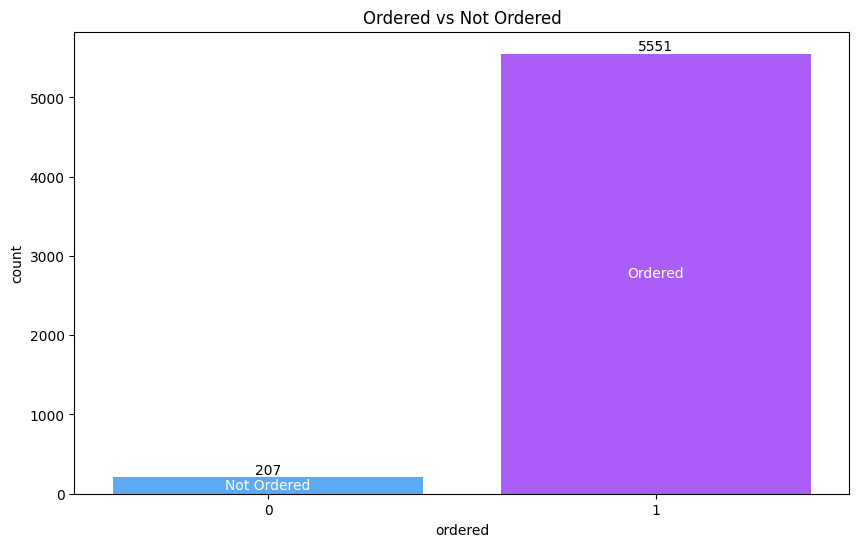

In [37]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = df2, x ='ordered', palette='cool',
                    saturation=0.9)
for container in ax.containers:
    ax.bar_label(container)
ax.bar_label(container=ax.containers[0], labels=['Not Ordered', 'Ordered'],
              label_type='center', size=10, color='w')
plt.title("Ordered vs Not Ordered")
plt.show()

In [38]:
df2 = df2.drop("next_day", axis=1)

# Mengubah index dataframe menjadi kolom "Date"
df2 = df2.set_index('Date')

# Membuat range tanggal mulai dari tanggal pertama hingga tanggal terakhir
date_range = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq='D')

# Membuat dataframe baru dengan index berdasarkan date range
df3 = pd.DataFrame(index=date_range)

# Menggabungkan dataframe df3 dengan df2 untuk melengkapi tanggal
df_complete = df3.merge(df2, how = 'left', left_index = True, right_index = True)

# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai sebelum dan sesudahnya
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)

# Mengatur ulang index menjadi kolom "Date"
df_complete = df_complete.reset_index()

df_complete = df_complete.rename(columns={"index": "Date"})

# Mengurutkan dataframe berdasarkan kolom "Date"
df_complete = df_complete.sort_values('Date')

# Mengubah tipe data kolom "Date" menjadi string
df_complete['Date'] = df_complete['Date'].dt.strftime('%Y-%m-%d')

In [39]:
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)

In [40]:
# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai terdekat
df_complete['Close'] = df_complete['Close'].fillna(df_complete['Close'].interpolate())

In [41]:
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete['day'] = df_complete['Date'].dt.day_name()

In [42]:
df_final2 = df_complete[~df_complete.day.isin(['Saturday',"Sunday"])]

In [43]:
df_final2['next_day'] = df_final2['Date'].shift(-1).dt.day_name()
df_final2 = df_final2.drop(['ordered'], axis=1).reset_index(drop=True)

<ipython-input-43-7faa69c177ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final2['next_day'] = df_final2['Date'].shift(-1).dt.day_name()


In [44]:
df_final2.fillna("Thursday", inplace=True)
df_final2['ordered'] = df_final2.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

In [45]:
df_final2.ordered.value_counts()

1    5970
Name: ordered, dtype: int64

In [46]:
df_final2

,Date,Close,day,next_day,ordered
0,1997-05-15,1.958333,Thursday,Friday,1
1,1997-05-16,1.729167,Friday,Monday,1
2,1997-05-19,1.708333,Monday,Tuesday,1
3,1997-05-20,1.635417,Tuesday,Wednesday,1
4,1997-05-21,1.427083,Wednesday,Thursday,1
...,...,...,...,...,...
5965,2020-03-26,1955.489990,Thursday,Friday,1
5966,2020-03-27,1900.099976,Friday,Monday,1
5967,2020-03-30,1963.949951,Monday,Tuesday,1
5968,2020-03-31,1949.719971,Tuesday,Wednesday,1


In [47]:
# Menentukan window size dan horizon
window_size = 5
horizon = 1

# Memisahkan data time series menjadi input dan output
input_data = []
output_data = []
for i in range(len(df_final2) - window_size - horizon + 1):
    if df_final2['day'].iloc[i:i+window_size].eq(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).all() and df_final2['day'].iloc[i + window_size:i + window_size + horizon].eq('Monday').all():
        input_data.append(df_final2['Close'].iloc[i:i + window_size].values)
        output_data.append(df_final2['Close'].iloc[i + window_size:i + window_size + horizon].values)

# Mengonversi menjadi DataFrame
input_df = pd.DataFrame(input_data, columns=[f'lag_{i}' for i in range(1, window_size + 1)])
output_df = pd.DataFrame(output_data, columns=['output'])

# Memisahkan dataset menjadi training, testing, dan validation set
total_samples = len(input_df)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)

train_input = input_df[:train_size]
train_output = output_df[:train_size]

val_input = input_df[train_size:train_size + val_size]
val_output = output_df[train_size:train_size + val_size]

test_input = input_df[train_size + val_size:]
test_output = output_df[train_size + val_size:]

# Menampilkan hasil
print("Training Data:")
print(train_input.shape)
print(train_output.shape)
print()
print("Validation Data:")
print(val_input.shape)
print(val_output.shape)
print()
print("Testing Data:")
print(test_input.shape)
print(test_output.shape)

Training Data:
(954, 5)
(954, 1)

Validation Data:
(119, 5)
(119, 1)

Testing Data:
(120, 5)
(120, 1)


In [48]:
# Konversi DataFrame menjadi array numpy
train_input = train_input.to_numpy()
train_output = train_output.to_numpy()
val_input = val_input.to_numpy()
val_output = val_output.to_numpy()
test_input = test_input.to_numpy()
test_output = test_output.to_numpy()

# Menentukan jumlah fitur dan timesteps
n_features = train_input.shape[1]
n_timesteps = 1

# Reshape input menjadi bentuk yang sesuai untuk model LSTM
train_input = train_input.reshape((train_input.shape[0], n_timesteps, n_features))
val_input = val_input.reshape((val_input.shape[0], n_timesteps, n_features))
test_input = test_input.reshape((test_input.shape[0], n_timesteps, n_features))


**b. Buat baseline architecture dengan LSTM (units = 50) dan layer akhir yang berupa node perceptron (units = 1). Gunakan ReLU sebagai activation function untuk LSTM.**

In [49]:
# Membangun model baseline dengan LSTM dan layer perceptron
model_baseline = Sequential()
model_baseline.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
model_baseline.add(Dense(1))
print(model_baseline.summary())
model_baseline.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
None


**c. Lakukan modifikasi arsitektur pada arsitektur 1b untuk mendapatkan hasil yang lebih
optimal (bisa dengan mengurangi/menambahkan arsitektur, atau mengganti
hyperparameter, atau melakukan tuning pada hyperparameter). Jelaskan alasan dipilihnya
pendekatan tersebut**

In [50]:
model_modified = Sequential()
model_modified.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features)))
model_modified.add(Dense(1))
print(model_modified.summary())

# Menyusun model
model_modified.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
None


**d. Lakukan evaluasi untuk kedua arsitektur di atas pada testing set dengan mencari MAE,
RMSE, dan MAPE nya. Berikan penjelasan mengenai hasilnya.**

In [52]:
# Melatih model baseline dan model yang dimodifikasi
batch_size = 32
model_baseline.fit(train_input, train_output, epochs=10, batch_size = batch_size ,validation_data=(val_input, val_output))
print()
model_modified.fit(train_input, train_output, epochs=20, batch_size = batch_size ,validation_data=(val_input, val_output))

Epoch 1/10
30/30 [==============================] - 1s 19ms/step - loss: 53.6203 - val_loss: 3416.5012
Epoch 2/10
30/30 [==============================] - 0s 16ms/step - loss: 55.5202 - val_loss: 366.0977
Epoch 3/10
30/30 [==============================] - 0s 16ms/step - loss: 33.3915 - val_loss: 347.2894
Epoch 4/10
30/30 [==============================] - 0s 15ms/step - loss: 30.5198 - val_loss: 428.6058
Epoch 5/10
30/30 [==============================] - 0s 13ms/step - loss: 43.4637 - val_loss: 346.8177
Epoch 6/10
30/30 [==============================] - 0s 13ms/step - loss: 45.9742 - val_loss: 346.9239
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 29.8821 - val_loss: 634.1915
Epoch 8/10
30/30 [==============================] - 0s 11ms/step - loss: 38.3645 - val_loss: 1271.2573
Epoch 9/10
30/30 [==============================] - 0s 13ms/step - loss: 38.2886 - val_loss: 832.3522
Epoch 10/10
30/30 [==============================] - 0s 10ms/step - loss: 23.075

In [53]:
# Melakukan prediksi pada data pengujian menggunakan model baseline
predictions_baseline = model_baseline.predict(test_input)

# Melakukan prediksi pada data pengujian menggunakan model yang dimodifikasi
predictions_modified = model_modified.predict(test_input)

# Menghitung metrik evaluasi MAE, RMSE, dan MAPE untuk model baseline
mae_baseline = mean_absolute_error(test_output, predictions_baseline)
rmse_baseline = np.sqrt(mean_squared_error(test_output, predictions_baseline))
mape_baseline = np.mean(np.abs((test_output - predictions_baseline) / test_output)) * 100

# Menghitung metrik evaluasi MAE, RMSE, dan MAPE untuk model yang dimodifikasi
mae_modified = mean_absolute_error(test_output, predictions_modified)
rmse_modified = np.sqrt(mean_squared_error(test_output, predictions_modified))
mape_modified = np.mean(np.abs((test_output - predictions_modified) / test_output)) * 100

# Menampilkan hasil evaluasi
print("Metrik Evaluasi Model Baseline:")
print("MAE:", mae_baseline)
print("RMSE:", rmse_baseline)
print("MAPE:", mape_baseline)
print()
print("Metrik Evaluasi Model yang Dimodifikasi:")
print("MAE:", mae_modified)
print("RMSE:", rmse_modified)
print("MAPE:", mape_modified)

4/4 [==============================] - 0s 3ms/step
Metrik Evaluasi Model Baseline:
MAE: 158.83347447713217
RMSE: 166.21590709138263
MAPE: 9.253424603442442

Metrik Evaluasi Model yang Dimodifikasi:
MAE: 34.63879470825194
RMSE: 46.09267413527869
MAPE: 2.038806015602494



Hasil evaluasi menunjukkan metrik evaluasi untuk kedua model, yaitu Model Baseline dan Model yang Dimodifikasi.

1. Model Baseline:

* MAE (Mean Absolute Error): Nilai MAE sebesar 185.32 menunjukkan rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin tinggi nilai MAE, semakin besar rata-rata kesalahan prediksi model baseline adalah sekitar 185.32.
* RMSE (Root Mean Square Error): Nilai RMSE sebesar 193.50 menunjukkan akar kuadrat dari rata-rata kesalahan kuadrat antara prediksi dan nilai sebenarnya pada testing set. Semakin tinggi nilai RMSE, semakin besar rata-rata kesalahan prediksi model baseline adalah sekitar 193.50.
* MAPE (Mean Absolute Percentage Error): Nilai MAPE sebesar 10.80 menunjukkan rata-rata persentase kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin tinggi nilai MAPE, semakin besar rata-rata persentase kesalahan prediksi model baseline adalah sekitar 10.80%.

2. Model yang Dimodifikasi:

* MAE (Mean Absolute Error): Nilai MAE sebesar 34.64 menunjukkan rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai MAE, semakin kecil rata-rata kesalahan prediksi model yang dimodifikasi adalah sekitar 34.64.
* RMSE (Root Mean Square Error): Nilai RMSE sebesar 46.09 menunjukkan akar kuadrat dari rata-rata kesalahan kuadrat antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai RMSE, semakin kecil rata-rata kesalahan prediksi model yang dimodifikasi adalah sekitar 46.09.
* MAPE (Mean Absolute Percentage Error): Nilai MAPE sebesar 2.04 menunjukkan rata-rata persentase kesalahan absolut antara prediksi dan nilai sebenarnya pada testing set. Semakin rendah nilai MAPE, semakin kecil rata-rata persentase kesalahan prediksi model yang dimodifikasi adalah sekitar 2.04%.
Dalam kasus ini, model yang dimodifikasi memberikan performa yang lebih baik daripada model baseline. Model yang dimodifikasi memiliki nilai MAE, RMSE, dan MAPE yang lebih rendah, menunjukkan bahwa prediksi model tersebut lebih dekat dengan nilai sebenarnya pada testing set. Model baseline, di sisi lain, memiliki nilai kesalahan yang jauh lebih tinggi.

References:
* https://deallen7.medium.com/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab
* https://medium.com/geekculture/8-use-cases-of-most-powerful-python-functions-apply-and-lambda-8e2d03e3e175
* https://towardsdatascience.com/all-the-pandas-shift-you-should-know-for-data-analysis-791c1692b5e
* https://medium.com/codestorm/pandas-reset-index-complete-guide-to-learn-python-db73551ac20d
* https://medium.com/@riat06/basics-for-datetime-in-pandas-48f3b68b1ae6
* https://soumenatta.medium.com/the-ultimate-guide-to-handling-missing-data-in-python-pandas-a6b0913a7cd4
* https://medium.com/@arsalan_zafar/dates-and-time-series-in-pandas-64d7c50e9949
* https://towardsdatascience.com/what-to-do-if-a-time-series-is-growing-but-not-in-length-421fc84c6893
* https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9
* https://keras.io/api/layers/regularization_layers/dropout/
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* Xiao, M., Wu, Y., Zuo, G., Fan, S., Yu, H., Shaikh, Z.A., & Wen, Z. (2021). Addressing Overfitting Problem in Deep Learning-Based Solutions for Next Generation Data-Driven Networks. Wirel. Commun. Mob. Comput., 2021, 8493795:1-8493795:10.
* Wegayehu, E.B., & Muluneh, F.B. (2022). Short-Term Daily Univariate Streamflow Forecasting Using Deep Learning Models. Advances in Meteorology.
* Orochi, O.P., & Kabari, L. (2021). Predicting Stock Price in Python Using Tensor Flow and Keras. International Journal of Research and Scientific Innovation.

